In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from IPython.display import Image, display_png

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg
Qt5Agg: unable to import specified backend (or its dependency); no plots


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.
Traceback (most recent call last):
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot.py", line 57, in uti_plot_init
    _backend = uti_plot_matplotlib.Backend(backend, fname_format)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 27, in __init__
    backend = self._init_ipython(backend)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/oasys_srw/uti_plot_matplotlib.py", line 724, in _init_ipython
    get_ipython().magic('matplotlib ' + b)
  File "/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

In [4]:
exp_type = 'peak_fwhm_nlpi'

In [5]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type / 'all_motors_beam'
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [5]:
!ls {data_base_dir}

autofocusing.ini
initial_motor_positions.json
peak_fwhm_nlpi_moo_100_2022-11-22_images
peak_fwhm_nlpi_moo_100_2022-11-22_steps
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_14:19.gz


### peak_fwhm_150_2022-11-18

In [6]:
!ls {data_base_dir}

autofocusing.ini
initial_motor_positions.json
peak_fwhm_nlpi_moo_100_2022-11-22_images
peak_fwhm_nlpi_moo_100_2022-11-22_steps
peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_14:19.gz


In [8]:
log_file = Path(data_base_dir / 'peak_fwhm_nlpi_moo_optimization_final_101_2022-11-22_14:19.gz')
log_file.exists()

True

In [10]:
hist_dir = Path(data_base_dir / 'peak_fwhm_nlpi_moo_100_2022-11-22_steps')
hist_dir.exists()

True

In [11]:
study = analysis.create_study_from_trials(log_file, n_objectives=3)

[I 2022-11-22 17:11:31,402] A new study created in memory with name: no-name-f57b404f-3a80-4aeb-8c12-571a6f0a9891


Assuming minimization for all objectives.


In [12]:
n_steps = len(study.trials)

In [13]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

Trial values: peak_distance 2.244e-02 fwhm 1.985e-02 nlpi -1.081e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3943914793975353, 'h_fwhm': 0.01690782769800947, 'h_centroid': -0.0017291571494513214, 'h_peak': -0.0224353867531264, 'v_sigma': 0.4622007832186319, 'v_fwhm': 0.010404064087534692, 'v_centroid': 0.0055967176937886665, 'v_peak': -0.00032512700273549627, 'integral_intensity': 278.8805207014857, 'peak_intensity': 49412.332, 'gaussian_fit': {}}}


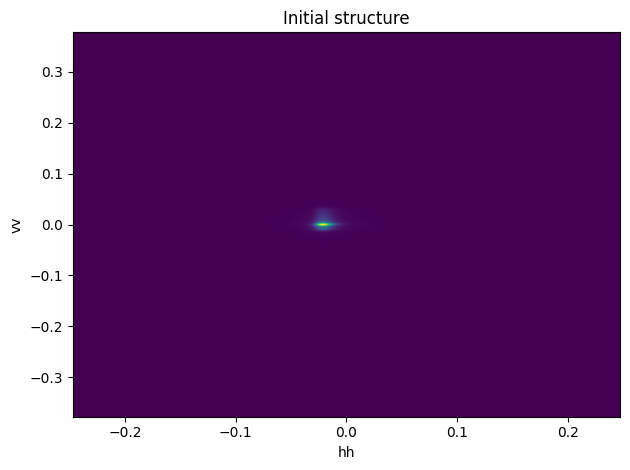

In [14]:
print(f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} " +
     f"nlpi {study.trials[0].values[2]:4.3e}")
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)


plt.pcolormesh(hists[0].hh[700:-700], hists[0].vv[700:-700], hists[0].data_2D[700:-700,700:-700].T)
plt.xlabel('hh')
plt.ylabel('vv')
plt.title("Initial structure")
plt.tight_layout()
plt.show()

In [15]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [16]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[97, 19, 89, 25]
18 [0.005141044125161722, 0.01731520387632536, -10.987288475036621]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39625545587721256, 'h_fwhm': 0.014306623436777244, 'h_centroid': -0.0009045432020981514, 'h_peak': -0.004877257989810118, 'v_sigma': 0.4644619774930496, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.0054774824564656766, 'v_peak': 0.0016256350136771857, 'integral_intensity': 276.07962559766685, 'peak_intensity': 59117.89, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.01731520387632536


Trial number 18
Trial values: peak_distance 5.141e-03 fwhm 1.732e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39625545587721256, 'h_fwhm': 0.014306623436777244, 'h_centroid': -0.0009045432020981514, 'h_peak': -0.004877257989810118, 'v_sigma': 0.4644619774930496, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.0054774824564656766, 'v_peak': 0.0016256350136771857, 'integral_intensity': 276.07962559766685, 'peak_intensity': 59117.89, 'gaussian_fit': {}}}
Actual fwhm 0.01731520387632536


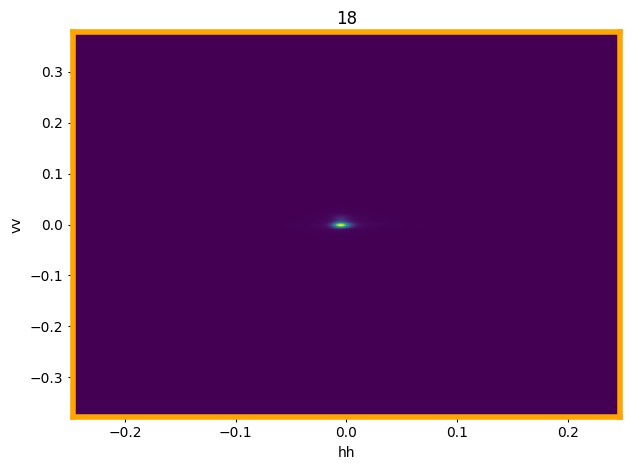

Trial number 38
Trial values: peak_distance 1.206e-01 fwhm 1.658e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3972997781623852, 'h_fwhm': 0.0149569245020853, 'h_centroid': 0.0012887751266546787, 'h_peak': 0.056901343214451186, 'v_sigma': 0.46592538230364366, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.001724184335414991, 'v_peak': 0.10631652989448999, 'integral_intensity': 274.52964090970113, 'peak_intensity': 63102.145, 'gaussian_fit': {}}}
Actual fwhm 0.016579265768677073


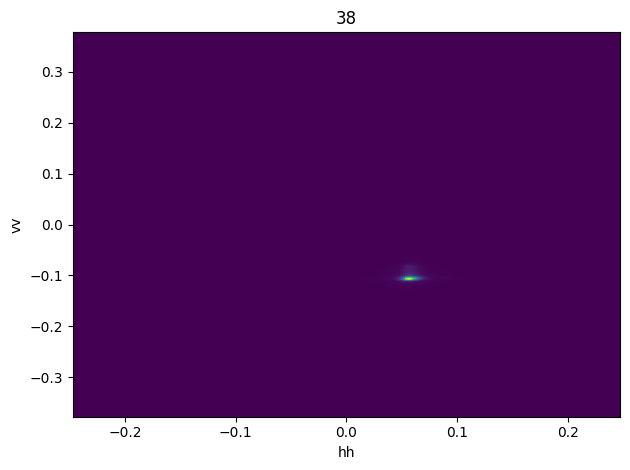

Trial number 53
Trial values: peak_distance 1.175e-02 fwhm 1.717e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39729961351168547, 'h_fwhm': 0.015607225567393357, 'h_centroid': -0.000656526759987841, 'h_peak': 0.0029263547938860714, 'v_sigma': 0.4658136540330734, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.005163225533433374, 'v_peak': 0.011379445095740449, 'integral_intensity': 274.15395101326925, 'peak_intensity': 57108.332, 'gaussian_fit': {}}}
Actual fwhm 0.017168225091104924


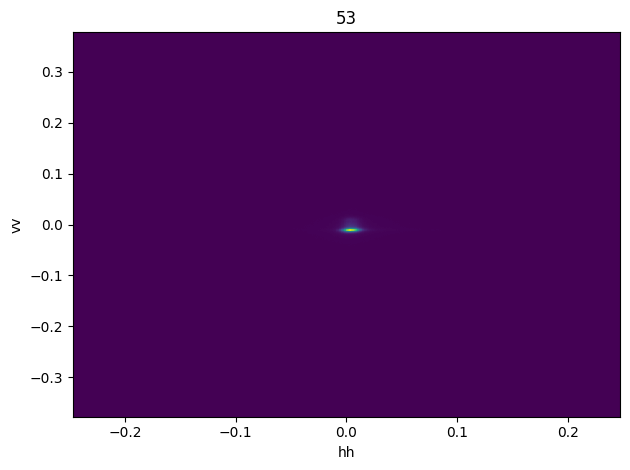

Trial number 78
Trial values: peak_distance 9.209e-02 fwhm 1.573e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3977066001319028, 'h_fwhm': 0.013656322371469187, 'h_centroid': -0.0037301447519993425, 'h_peak': -0.08356368689207971, 'v_sigma': 0.4661181976475602, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.007105682407930497, 'v_peak': -0.038690113325517854, 'integral_intensity': 273.58126884222804, 'peak_intensity': 53902.875, 'gaussian_fit': {}}}
Actual fwhm 0.015728404236550825


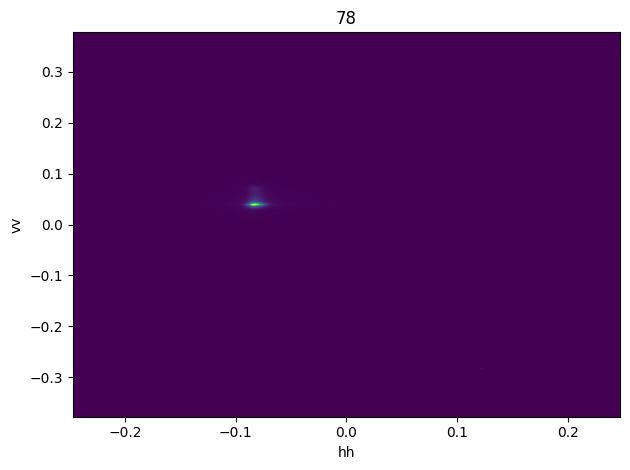

CA client library is unable to contact CA repeater after 50 tries.
Silence this message by starting a CA repeater daemon
or by calling ca_pend_event() and or ca_poll() more often.


In [17]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700,700:-700].T)
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color('orange')
    plt.xlabel('hh')
    plt.ylabel('vv')
    plt.title(t.number)
    plt.tight_layout()
    plt.show()

In [18]:
study.best_trials[0].values

[0.005141044125161722, 0.01731520387632536, -10.987288475036621]

In [19]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ['peak_distance', 'delta_fwhm', 'nlpi'])

In [20]:
pareto_df

,number,peak_distance,delta_fwhm,nlpi,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
18,18,0.005141,0.017315,-10.987288,-0.004877,0.001626,0.014307,0.009754,59117.890625
38,38,0.120586,0.016579,-11.052510,0.056901,0.106317,0.014957,0.007153,63102.144531
53,53,0.011750,0.017168,-10.952705,0.002926,0.011379,0.015607,0.007153,57108.332031
78,78,0.092086,0.015728,-10.894939,-0.083564,-0.038690,0.013656,0.007803,53902.875000


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4062/2375896861.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["peak_distance", "delta_fwhm", "nlpi"], include_dominated_trials=False)


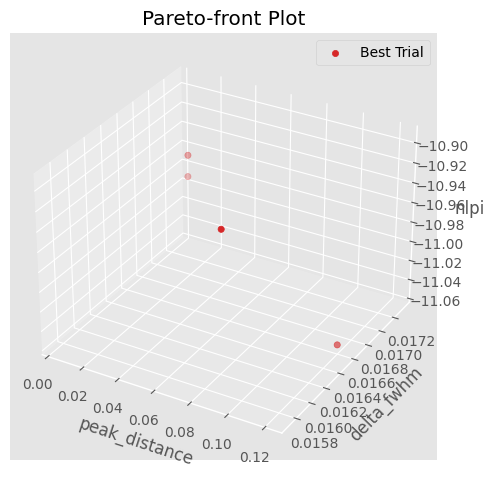

In [21]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["peak_distance", "delta_fwhm", "nlpi"], include_dominated_trials=False)
#plt.scatter(*nash_trial.values, color='orange', label='Nash')
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig(...) to save the image
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4062/320309324.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="peak_distance")


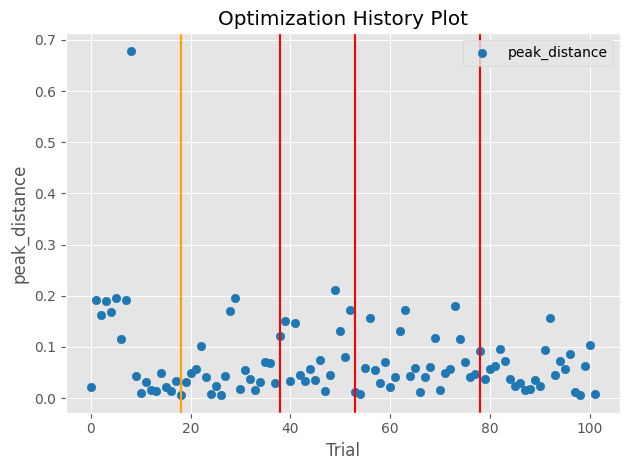

In [22]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="peak_distance")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4062/1279663034.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="delta_fwhm")


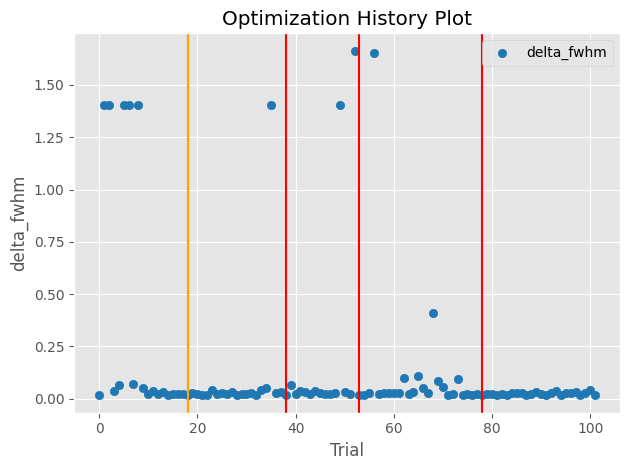

In [23]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="delta_fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4062/3199083138.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[2], target_name="nlpi")


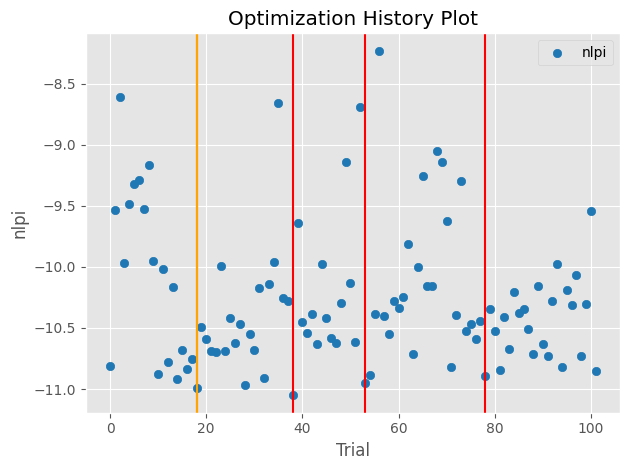

In [24]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[2], target_name="nlpi")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### The remaining part is just testing how lwsi with thresholding performs in selecting the structures. This is for my own satisfaction. - SK

In [ ]:
isums = []
wsums_no_thres = []
wsums_thres = []
for h in hists:
    isum1, wsum1 = analysis.calculate_weighted_sum(h, threshold=0)
    isum2, wsum2 = analysis.calculate_weighted_sum(h)
    isums.append((isum1, isum2))
    wsums_no_thres.append(wsum1)
    wsums_thres.append(wsum2)
isums = np.array(isums)
wsums_no_thres = np.array(wsums_no_thres)
wsums_thres = np.array(wsums_thres)
                      

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4062/214102518.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),


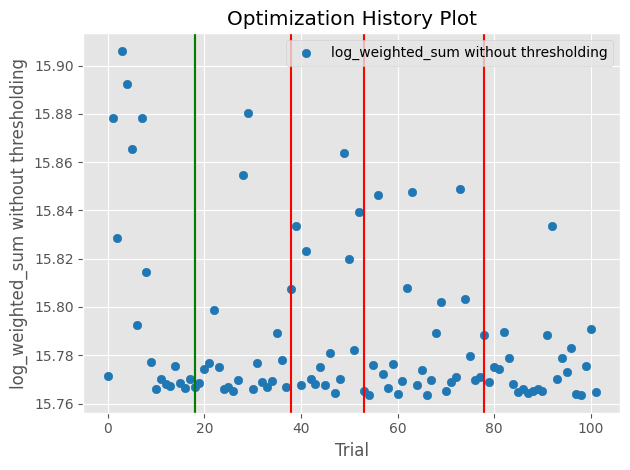

In [26]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_no_thres[t.number]),
                                                          target_name="log_weighted_sum without thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_4062/2958963105.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),


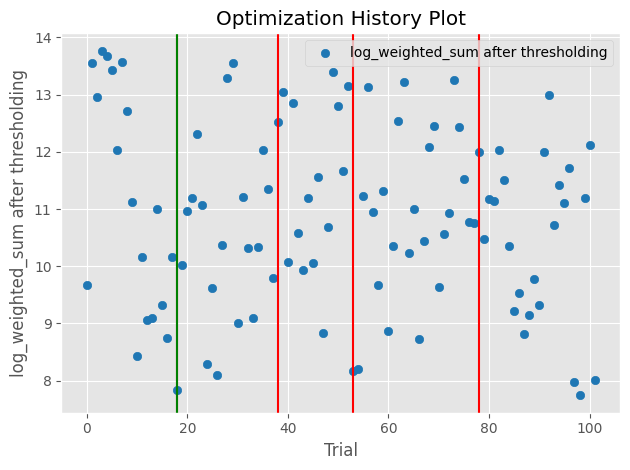

In [27]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums_thres[t.number]),
                                                          target_name="log_weighted_sum after thresholding")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [28]:
test_val_fns = [lambda t: t.values[0], lambda t: t.values[2], lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, study.directions, values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins))

18


18 [0.005141044125161722, -10.987288475036621, 7.832236571125931]


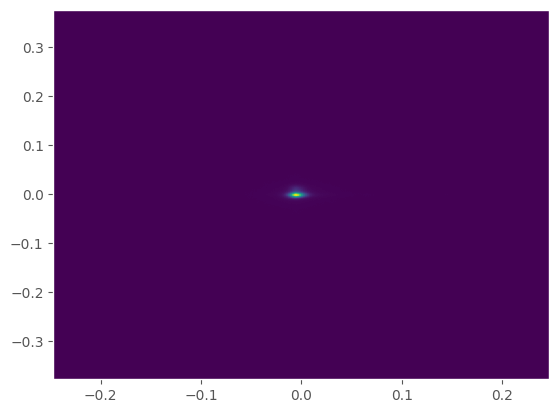

38 [0.12058593362583694, -11.052510261535645, 12.516071578088763]


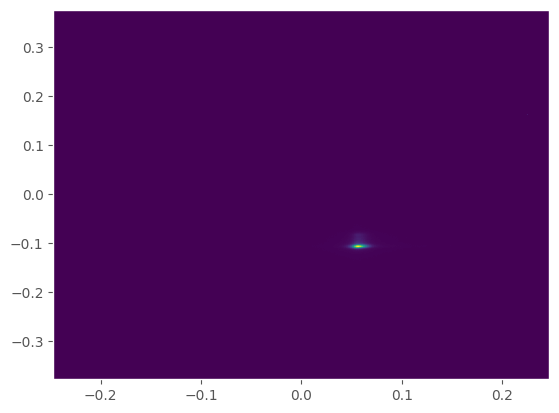

98 [0.00683549445134668, -10.72607135772705, 7.740023168335555]


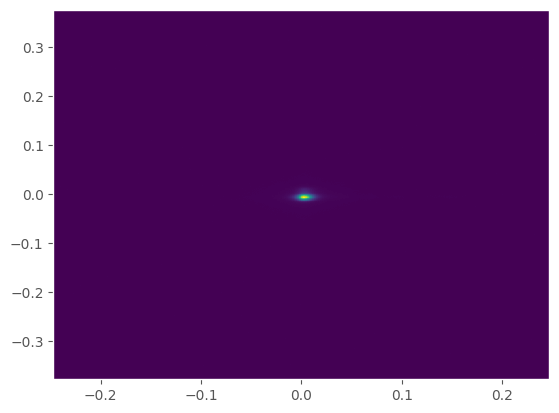

In [29]:
for t in test_pareto:
    print(t.number, test_values[t.number])
    hdata = hists[t.number]
    
    plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)
    plt.show()

In [30]:
test_val_fns = [lambda t: t.values[0], lambda t: opt_common._get_fwhm_from_dw(t.user_attrs['dw']), lambda t: np.log(wsums_thres[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)

domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1, 1], test_val_fns)
print(np.argmax(domins), domins[np.argmax(domins)])

18 96
